In [ ]:
!pip install kaggle tensorflow matplotlib tqdm

import os
import glob
import re
import gc
from typing import Dict, List, Text, Tuple, Callable, Optional

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm

from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Conv2DTranspose,
                                     Concatenate, Input, BatchNormalization,
                                     Activation, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU, Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K

print(f"TensorFlow Version: {tf.__version__}")
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU detected: {gpu_devices}")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print("On CPU")

K.clear_session()

TensorFlow Version: 2.18.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Setting up kaggle and downloading the dataset

In [ ]:
!mkdir -p ~/.kaggle

!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle API token configured.")


kaggle_dataset_id = "georgehulsey/modified-next-day-wildfire-spread"
download_path = "./data"

!mkdir -p {download_path}

print(f"Downloading dataset: {kaggle_dataset_id}...")
!kaggle datasets download -d {kaggle_dataset_id} -p {download_path} --unzip -q

dataset_folder = os.path.join(download_path, "ndws_western_dataset")
print(f"Dataset downloaded and unzipped successfully to: {dataset_folder}")
print("\nSample files found:")
try:
    for f in os.listdir(dataset_folder)[:5]:
        print(f"- {f}")
except Exception as e:
    print(f"Could not list files: {e}")


Kaggle API token configured.
Dataset URL: https://www.kaggle.com/datasets/georgehulsey/modified-next-day-wildfire-spread
License(s): apache-2.0
Dataset downloaded and unzipped successfully to: ./data/ndws_western_dataset

Sample files found:
- cleaned_train_ndws_conus_western_009.tfrecord
- cleaned_eval_ndws_conus_western_008.tfindex
- cleaned_eval_ndws_conus_western_003.tfrecord
- cleaned_test_ndws_conus_western_011.tfindex
- cleaned_eval_ndws_conus_western_009.tfrecord


Setting up and inspecting the wildfire progression dataset (NDWS Western Dataset) stored in TFRecord format.


In [ ]:
DATASET_PATH = "./data/ndws_western_dataset"
BATCH_SIZE = 16
IMG_HEIGHT = 64
IMG_WIDTH = 64

INPUT_FEATURES = ['elevation', 'wind_75', 'wind_avg', 'tmp_75', 'tmp_day', 'avg_sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'viirs_PrevFireMask']
OUTPUT_FEATURES = ['viirs_FireMask']
NUM_INPUT_FEATURES = len(INPUT_FEATURES)
NUM_OUTPUT_FEATURES = len(OUTPUT_FEATURES)

FEATURE_TITLES = {
    'elevation': "Elevation\n(m)",
    'wind_75': "Wind speed\nat 75m (m/s)",
    'wind_avg': "Average\nwind speed (m/s)",
    'tmp_75': "Temperature\nat 75m (K)",
    'tmp_day': "Daytime\ntemperature (K)",
    'avg_sph': "Average\nspecific humidity",
    'pr': "Precipitation\n(mm, daily total)",
    'pdsi': "Drought\nindex (PDSI)",
    'NDVI': "Vegetation\nindex (NDVI)",
    'population': "Population\ndensity\n(people per km²)",
    'erc': "Energy\nrelease component\n(index)",
    'viirs_PrevFireMask': "Previous\nday fire mask",
    'viirs_FireMask': "Fire\nmask (Label)",
    'chili': "Topographic\nposition index",
    'impervious': "Impervious\nsurface (%)",
    'water': "Water\n(% cover)",
    'fuel1': "Fuel type 1",
    'fuel2': "Fuel type 2",
    'fuel3': "Fuel type 3",
    'bi': "Burning\nindex",
    'gust_med': "Wind\ngust speed (m/s)",
    'wdir_wind': "Wind\ndirection\n(degree)",
    'wdir_gust': "Wind\ngust direction\n(degree)",
}

FEATURE_RANGES = {
    'elevation': (1750.0, 2500.0),
    'wind_75': (0.5, 6.0),
    'wind_avg': (0.5, 5.0),
    'tmp_75': (280.0, 320.0),
    'tmp_day': (280.0, 320.0),
    'avg_sph': (0.005, 0.015),
    'pr': (0.0, 10.0),
    'pdsi': (-5.0, 5.0),
    'NDVI': (0.0, 1.0),
    'population': (0.0, 1000.0),
    'erc': (0.0, 100.0),
    'viirs_PrevFireMask': None,
    'viirs_FireMask': None,
}

tfrecord_files_list = glob.glob(os.path.join(DATASET_PATH, "*.tfrecord"))
if not tfrecord_files_list:
    raise FileNotFoundError("No TFRecord files found. Check DATASET_PATH.")
print(f"Using file for inspection: {tfrecord_files_list[0]}")
raw_dataset_inspect = tf.data.TFRecordDataset(tfrecord_files_list[0])
for raw_record in raw_dataset_inspect.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    ALL_TFRECORD_FEATURES = list(example.features.feature.keys())
print(f"Detected features in TFRecord: {ALL_TFRECORD_FEATURES}")


RAW_FEATURE_DESC = {
    feature: tf.io.FixedLenFeature([IMG_HEIGHT, IMG_WIDTH], tf.float32)
    for feature in ALL_TFRECORD_FEATURES
}

all_files = sorted(glob.glob(os.path.join(DATASET_PATH, "*.tfrecord")))
train_files_pattern = os.path.join(DATASET_PATH, "*train*.tfrecord")
val_files_pattern = os.path.join(DATASET_PATH, "*eval*.tfrecord")
test_files_pattern = os.path.join(DATASET_PATH, "*test*.tfrecord")


print(f"Train files pattern: {train_files_pattern}")
print(f"Validation files pattern: {val_files_pattern}")
print(f"Test files pattern: {test_files_pattern}")

Using file for inspection: ./data/ndws_western_dataset/cleaned_train_ndws_conus_western_009.tfrecord
Detected features in TFRecord: ['gust_med', 'wind_75', 'elevation', 'population', 'chili', 'impervious', 'fuel3', 'viirs_PrevFireMask', 'fuel2', 'viirs_FireMask', 'fuel1', 'pdsi', 'water', 'tmp_day', 'erc', 'NDVI', 'pr', 'wdir_wind', 'wdir_gust', 'bi', 'tmp_75', 'avg_sph', 'wind_avg']
Train files pattern: ./data/ndws_western_dataset/*train*.tfrecord
Validation files pattern: ./data/ndws_western_dataset/*eval*.tfrecord
Test files pattern: ./data/ndws_western_dataset/*test*.tfrecord


This section sets up the data input pipeline for training and evaluating wildfire spread models using TensorFlow:

- **`normalize_feature()`**: Scales input features based on predefined ranges. Special handling is applied for `viirs_PrevFireMask` and output labels.

- **`_parse_function()`**: Parses a single TFRecord into a multi-channel input tensor and a binary output mask (`[64, 64, 1]`).

- **`get_dataset()`**: Loads `.tfrecord` files using `interleave`, applies parsing, and prepares the dataset with caching, shuffling, batching, and prefetching.

In [ ]:
def normalize_feature(feature: tf.Tensor, feature_name: str) -> tf.Tensor:
    if feature_name == 'viirs_PrevFireMask':
        return feature * 5.0

    feat_range = FEATURE_RANGES.get(feature_name)

    if feat_range:
        min_val, max_val = feat_range
        norm = (feature - min_val) / (max_val - min_val + K.epsilon())
        return tf.clip_by_value(norm, 0.0, 1.0)
    else:
        if feature_name in ['viirs_FireMask']:
            return tf.clip_by_value(feature, 0.0, 1.0)
        return feature


def _parse_function(example_proto: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    parsed_example = tf.io.parse_single_example(example_proto, RAW_FEATURE_DESC)

    inputs_list = []
    for feature_name in INPUT_FEATURES:
        feature = parsed_example[feature_name]
        normalized_feature = normalize_feature(feature, feature_name)
        inputs_list.append(tf.expand_dims(normalized_feature, axis=-1))

    inputs_tensor = tf.concat(inputs_list, axis=-1)

    label_name = OUTPUT_FEATURES[0]
    label_tensor = parsed_example[label_name]
    processed_label = tf.clip_by_value(label_tensor, 0.0, 1.0)
    processed_label = tf.expand_dims(processed_label, axis=-1)

    return inputs_tensor, processed_label


def get_dataset(file_pattern: str, batch_size: int, shuffle: bool = True, repeat: bool = False) -> tf.data.Dataset:
    files = tf.data.Dataset.list_files(file_pattern, shuffle=shuffle)

    dataset = files.interleave(
        lambda x: tf.data.TFRecordDataset(x),
        cycle_length=tf.data.AUTOTUNE,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.cache()

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size)

    if repeat:
        dataset = dataset.repeat()

    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset



train_dataset = get_dataset(train_files_pattern, batch_size=BATCH_SIZE, shuffle=True, repeat=True)
validation_dataset = get_dataset(val_files_pattern, batch_size=BATCH_SIZE, shuffle=False, repeat=True)
test_dataset = get_dataset(test_files_pattern, batch_size=BATCH_SIZE, shuffle=False, repeat=False)

def count_tfrecords(file_pattern):
    count = 0
    filenames = tf.io.gfile.glob(file_pattern)
    if not filenames: return 0
    raw_dataset = tf.data.TFRecordDataset(filenames)
    print(f"Counting records for {file_pattern}...")
    for _ in tqdm(raw_dataset):
        count += 1
    return count

num_train_samples = count_tfrecords(train_files_pattern)
num_val_samples = count_tfrecords(val_files_pattern)
num_test_samples = count_tfrecords(test_files_pattern)


STEPS_PER_EPOCH = num_train_samples // BATCH_SIZE
VALIDATION_STEPS = num_val_samples // BATCH_SIZE
print(f"Total Training Samples: {num_train_samples}")
print(f"Total Validation Samples: {num_val_samples}")
print(f"Total Test Samples: {num_test_samples}")
print(f"Steps per Epoch (Training): {STEPS_PER_EPOCH}")
print(f"Validation Steps per Epoch: {VALIDATION_STEPS}")

if train_dataset: print("Train dataset created successfully.")
if validation_dataset: print("Validation dataset created successfully.")
if test_dataset: print("Test dataset created successfully.")

Counting records for ./data/ndws_western_dataset/*train*.tfrecord...


9600it [00:01, 5374.21it/s]


Counting records for ./data/ndws_western_dataset/*eval*.tfrecord...


4301it [00:00, 5326.87it/s]


Counting records for ./data/ndws_western_dataset/*test*.tfrecord...


6196it [00:01, 5328.51it/s]

Total Training Samples: 9600
Total Validation Samples: 4301
Total Test Samples: 6196
Steps per Epoch (Training): 600
Validation Steps per Epoch: 268
Train dataset created successfully.
Validation dataset created successfully.
Test dataset created successfully.


Visualizing Sample Inputs and Labels from TFRecord Dataset

Plotting samples from Training Dataset...
Input tensor shape (Batch, Height, Width, Channels): (16, 64, 64, 12)
Label tensor shape (Batch, Height, Width, Channels): (16, 64, 64, 1)


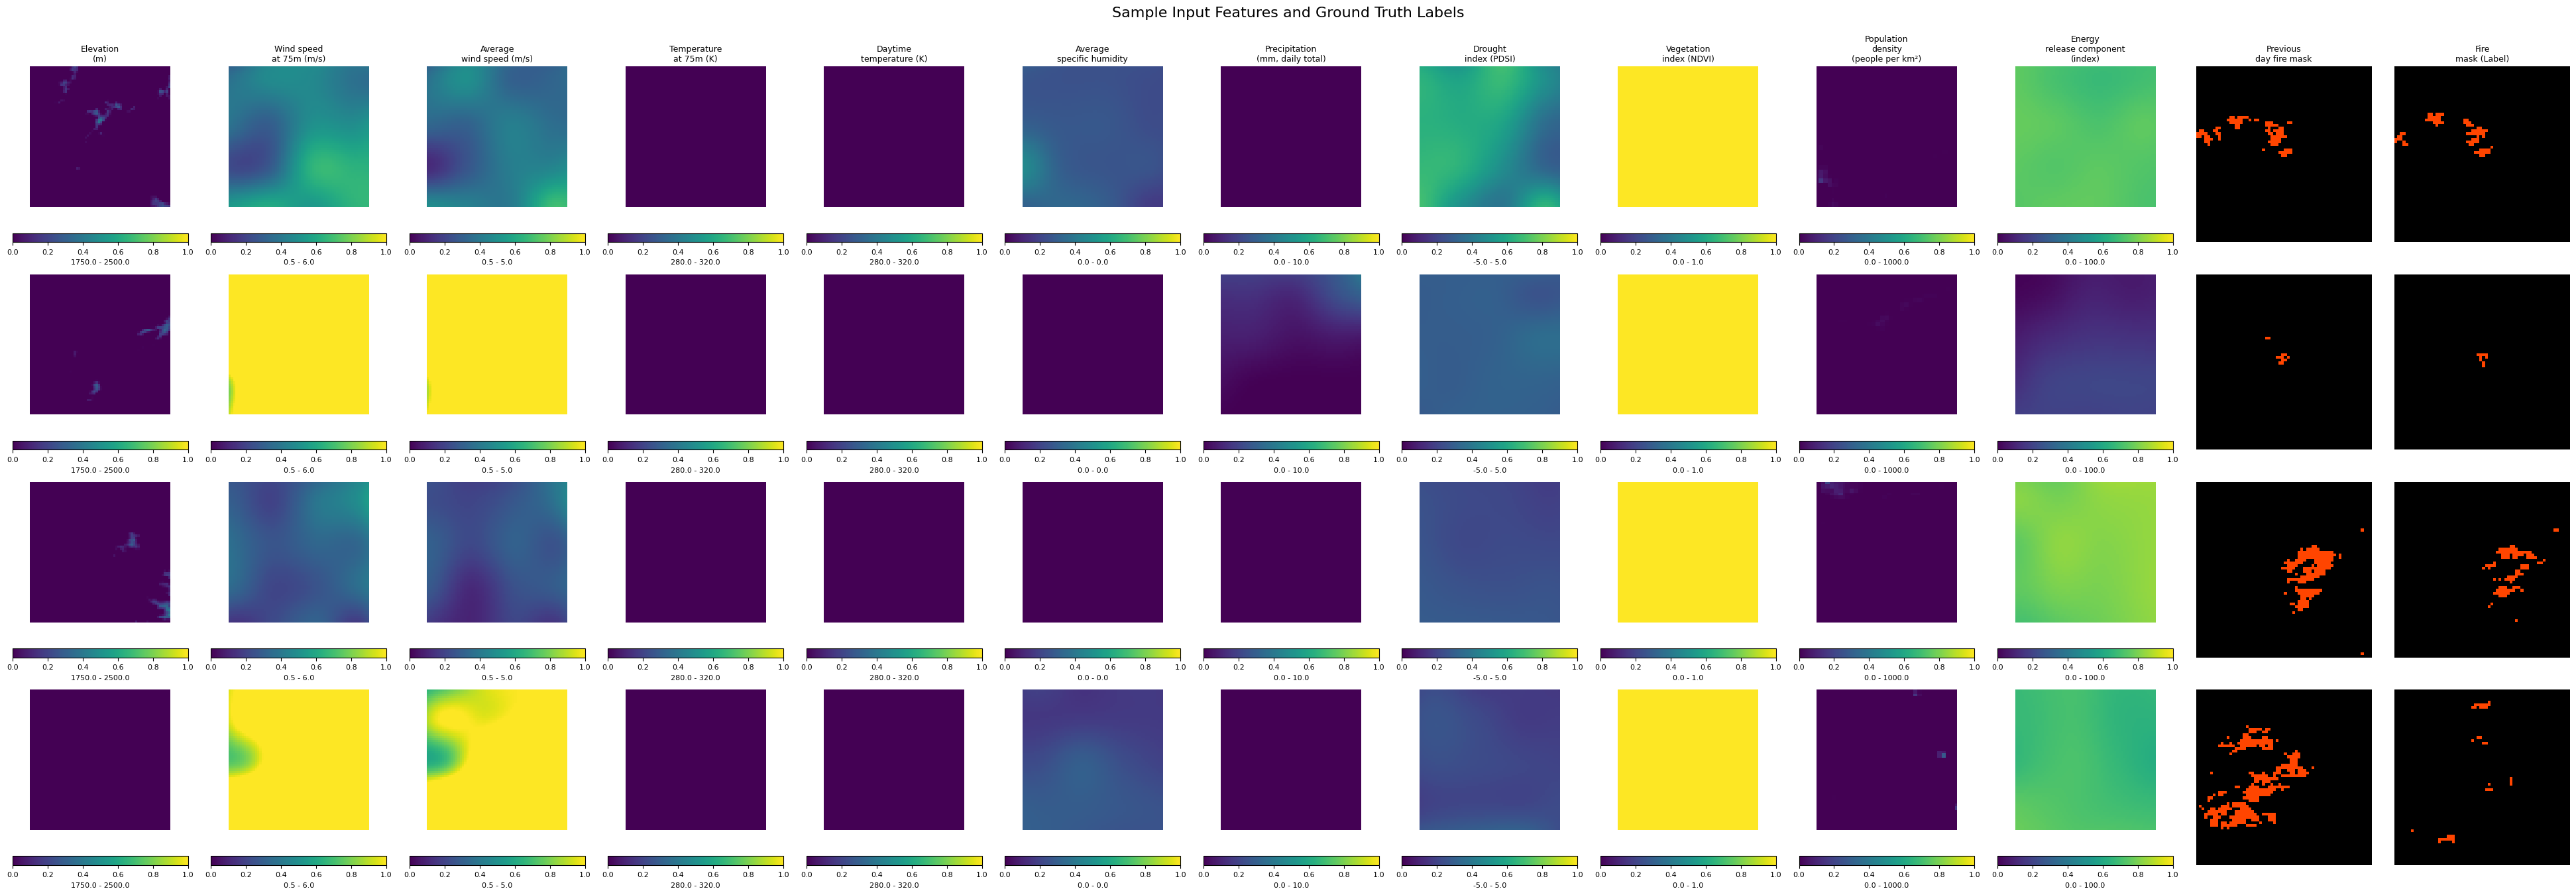

In [ ]:
def plot_samples_from_tf_dataset(dataset: tf.data.Dataset, n_rows: int, input_features_list: List = INPUT_FEATURES, feature_titles_dict: Dict = FEATURE_TITLES):

    inputs, labels = next(iter(dataset))
    print("Input tensor shape (Batch, Height, Width, Channels):", inputs.shape)
    print("Label tensor shape (Batch, Height, Width, Channels):", labels.shape)


    num_features = inputs.shape[-1]
    actual_rows = min(n_rows, inputs.shape[0])

    fig, axes = plt.subplots(actual_rows, num_features + 1, figsize=(3 * (num_features + 1), 3.5 * actual_rows))
    if actual_rows == 1:
        axes = axes.reshape(1, -1)

    CMAP_MASK = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-0.1, 0.1, 1.1]
    NORM_MASK = colors.BoundaryNorm(BOUNDS, CMAP_MASK.N)

    for i in range(actual_rows):
        for j in range(num_features + 1):
            ax = axes[i, j]

            if j < num_features:
                feature_map = inputs[i, :, :, j].numpy()
                feature_name = input_features_list[j]
                title = feature_titles_dict.get(feature_name, f'Feature {j+1}')

                feature_range = FEATURE_RANGES.get(feature_name)
                vmin, vmax = (0, 1)
                cmap = 'viridis'
                if feature_name == 'viirs_PrevFireMask':
                     cmap = CMAP_MASK
                     norm = NORM_MASK
                     img = ax.imshow((feature_map > 0.1).astype(int), cmap=cmap, norm=norm)
                else:
                     img = ax.imshow(feature_map, cmap=cmap, vmin=vmin, vmax=vmax)
                     cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.15, fraction=0.05)
                     cbar.ax.tick_params(labelsize=8)
                     if feature_range:
                        cbar.set_label(f"{feature_range[0]:.1f} - {feature_range[1]:.1f}", fontsize=8)

                if i == 0:
                    ax.set_title(title, fontsize=9)
            else:
                label_map = labels[i, :, :, 0].numpy()
                title = feature_titles_dict.get('viirs_FireMask', 'Fire Mask\n(Label)')

                img = ax.imshow(label_map, cmap=CMAP_MASK, norm=NORM_MASK)
                if i == 0:
                    ax.set_title(title, fontsize=9)

            ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.suptitle("Sample Input Features and Ground Truth Labels", fontsize=16, y=0.99)
    plt.show()

print("Plotting samples from Training Dataset...")
plot_samples_from_tf_dataset(train_dataset, n_rows=4)


Custom Dice Coefficient Metric (Keras)

In [ ]:
class DiceCoefficient(tf.keras.metrics.Metric):
    def __init__(self, name="dice_coefficient", threshold=0.5, smooth=1e-6, **kwargs):
        super(DiceCoefficient, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.smooth = smooth
        self.intersection_sum = self.add_weight(name="intersection_sum", initializer="zeros")
        self.true_sum = self.add_weight(name="true_sum", initializer="zeros")
        self.pred_sum = self.add_weight(name="pred_sum", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_binary = tf.cast(y_pred > self.threshold, dtype=tf.float32)
        y_true = tf.cast(y_true, dtype=tf.float32)

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            y_true = y_true * sample_weight
            y_pred_binary = y_pred_binary * sample_weight

        intersection = tf.reduce_sum(y_true * y_pred_binary)
        true_sum = tf.reduce_sum(y_true)
        pred_sum = tf.reduce_sum(y_pred_binary)

        self.intersection_sum.assign_add(intersection)
        self.true_sum.assign_add(true_sum)
        self.pred_sum.assign_add(pred_sum)


    def result(self):
        dice = (2. * self.intersection_sum + self.smooth) / (self.true_sum + self.pred_sum + self.smooth)
        dice = tf.where(tf.math.is_nan(dice), tf.constant(0.0, dtype=dice.dtype), dice)
        return dice

    def reset_state(self):
        self.intersection_sum.assign(0.0)
        self.true_sum.assign(0.0)
        self.pred_sum.assign(0.0)

    def get_config(self):
        config = super(DiceCoefficient, self).get_config()
        config.update({"threshold": self.threshold, "smooth": self.smooth})
        return config

print("Custom DiceCoefficient metric defined. Using built-in MeanIoU.")

Custom DiceCoefficient metric defined. Using built-in MeanIoU.


Creating UNET architecture

In [ ]:
from tensorflow.keras.regularizers import l2

def build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_INPUT_FEATURES), num_classes=1, dropout_rate=0.3, l2_reg=1e-4):

    inputs = Input(shape=input_shape)

    def conv_block(x, filters, kernel_size=(3, 3), activation='relu', padding='same', use_batch_norm=True, use_dropout=False, rate=0.0, reg=None):
        x = Conv2D(filters, kernel_size, padding=padding, kernel_regularizer=reg)(x)
        if use_batch_norm:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
        x = Conv2D(filters, kernel_size, padding=padding, kernel_regularizer=reg)(x)
        if use_batch_norm:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
        if use_dropout:
            x = Dropout(rate)(x)
        return x

    c1 = conv_block(inputs, 64, use_dropout=True, rate=dropout_rate, reg=l2(l2_reg))
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128, use_dropout=True, rate=dropout_rate, reg=l2(l2_reg))
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256, use_dropout=True, rate=dropout_rate, reg=l2(l2_reg))
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512, use_dropout=True, rate=dropout_rate, reg=l2(l2_reg))
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 1024, use_dropout=True, rate=dropout_rate, reg=l2(l2_reg))

    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = Concatenate()([u6, c4])
    c6 = conv_block(u6, 512, use_dropout=True, rate=dropout_rate, reg=l2(l2_reg))

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = conv_block(u7, 256, use_dropout=True, rate=dropout_rate, reg=l2(l2_reg))

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = conv_block(u8, 128, use_dropout=True, rate=dropout_rate, reg=l2(l2_reg))

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = conv_block(u9, 64, use_dropout=True, rate=dropout_rate, reg=l2(l2_reg))

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid', padding='same')(c9)

    model = Model(inputs=inputs, outputs=outputs, name='U-Net_Wildfire')
    return model

unet_model = build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_INPUT_FEATURES), num_classes=NUM_OUTPUT_FEATURES)

unet_model.summary()

print(f"\nU-Net model built successfully with input shape {(IMG_HEIGHT, IMG_WIDTH, NUM_INPUT_FEATURES)}.")

Model: "U-Net_Wildfire"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ activation_3[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ dropout_1[0][0] 

 Total params: 31,060,481 (118.49 MB)

 Trainable params: 31,048,705 (118.44 MB)

 Non-trainable params: 11,776 (46.00 KB)


U-Net model built successfully with input shape (64, 64, 12).


In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))

    intersection = K.sum(y_true_f * y_pred_f)
    dice_coeff = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - dice_coeff

bce = BinaryCrossentropy(from_logits=False)

def combined_loss(y_true, y_pred, bce_weight=0.5, dice_weight=0.5):
    bce_val = bce(y_true, y_pred)
    dice_val = dice_loss(y_true, y_pred)
    return (bce_weight * bce_val) + (dice_weight * dice_val)

LEARNING_RATE = 0.001
CLIPNORM = 1.0

optimizer = Adam(learning_rate=LEARNING_RATE, clipnorm=CLIPNORM)

metrics = [
    tf.keras.metrics.MeanIoU(num_classes=2, name='mean_iou'),
    DiceCoefficient(name='dice_coeff'),
    Recall(name='recall'),
    Precision(name='precision')
]

unet_model.compile(
    optimizer=optimizer,
    loss=combined_loss,
    metrics=metrics
)

print("U-Net model compiled successfully.")
print(f"Optimizer: Adam (LR={LEARNING_RATE}, Clipnorm={CLIPNORM})")
print(f"Loss: Combined BCE + Dice")
print(f"Metrics: {[m.name for m in metrics]}")

U-Net model compiled successfully.
Optimizer: Adam (LR=0.001, Clipnorm=1.0)
Loss: Combined BCE + Dice
Metrics: ['mean_iou', 'dice_coeff', 'recall', 'precision']


Training

Starting model training...
Epoch 1/15
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - dice_coeff: 0.3898 - loss: 0.5532 - mean_iou: 0.4841 - precision: 0.3057 - recall: 0.5571
Epoch 1: val_dice_coeff improved from -inf to 0.47251, saving model to best_unet_model.keras
600/600 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - dice_coeff: 0.3900 - loss: 0.5528 - mean_iou: 0.4841 - precision: 0.3059 - recall: 0.5571 - val_dice_coeff: 0.4725 - val_loss: 0.3709 - val_mean_iou: 0.4853 - val_precision: 0.4676 - val_recall: 0.4775 - learning_rate: 0.0010
Epoch 2/15
598/600 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - dice_coeff: 0.4400 - loss: 0.3829 - mean_iou: 0.4843 - precision: 0.3939 - recall: 0.4984
Epoch 2: val_dice_coeff improved from 0.47251 to 0.48411, saving model to best_unet_model.keras
600/600 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - dice_coeff: 0.4401 - loss: 0.3828 - mean_iou: 0.4843 - precision: 0.3941 - recall: 0.4985 - val_dice_coeff: 0.4841 - val_loss: 0.3660 - val_mean_iou: 0.4853 - val_precision: 0.46

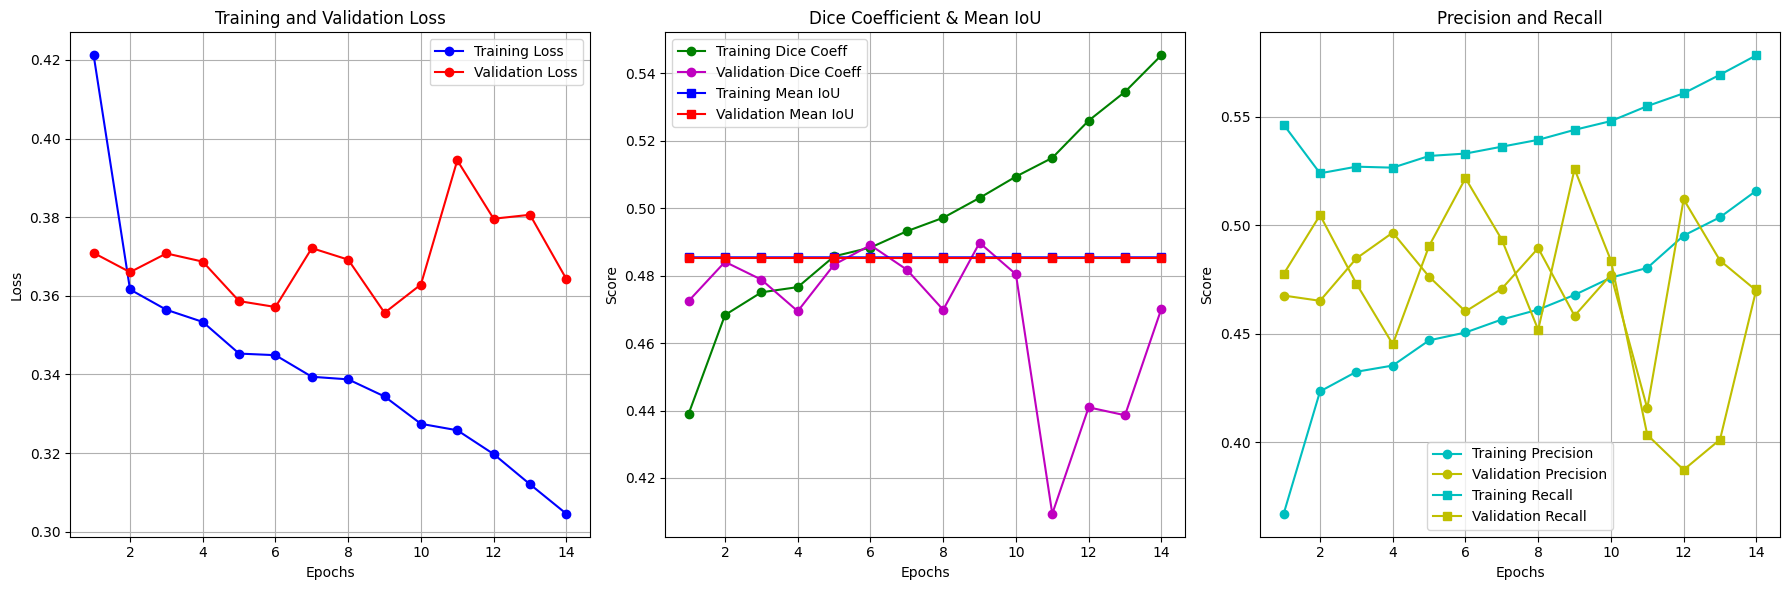

Loading best model from checkpoint for evaluation...
Best model loaded successfully.


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_dice_coeff',
    patience=5,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_dice_coeff',
    factor=0.7,
    patience=2,
    min_lr=1e-6,
    verbose=1,
    mode='max'
)

checkpoint = ModelCheckpoint(
    filepath="best_unet_model.keras",
    monitor="val_dice_coeff",
    save_best_only=True,
    verbose=1,
    mode='max',
    save_weights_only=False
)

EPOCHS = 15


print("Starting model training...")
history = unet_model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)
print("\nTraining finished.")

if history:
    def plot_tf_history(history):
        hist = history.history
        if not hist or 'loss' not in hist:
              print("No training history data found to plot.")
              return

        epochs = range(1, len(hist['loss']) + 1)

        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        plt.plot(epochs, hist['loss'], 'bo-', label='Training Loss')
        if 'val_loss' in hist: plt.plot(epochs, hist['val_loss'], 'ro-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 3, 2)
        if 'dice_coeff' in hist: plt.plot(epochs, hist['dice_coeff'], 'go-', label='Training Dice Coeff')
        if 'val_dice_coeff' in hist: plt.plot(epochs, hist['val_dice_coeff'], 'mo-', label='Validation Dice Coeff')
        if 'mean_iou' in hist: plt.plot(epochs, hist['mean_iou'], 'bs-', label='Training Mean IoU') # <-- Updated name
        if 'val_mean_iou' in hist: plt.plot(epochs, hist['val_mean_iou'], 'rs-', label='Validation Mean IoU') # <-- Updated name
        plt.title('Dice Coefficient & Mean IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        handles, labels = plt.gca().get_legend_handles_labels()
        if labels: plt.legend()
        plt.grid(True)

        plt.subplot(1, 3, 3)
        if 'precision' in hist: plt.plot(epochs, hist['precision'], 'co-', label='Training Precision')
        if 'val_precision' in hist: plt.plot(epochs, hist['val_precision'], 'yo-', label='Validation Precision')
        if 'recall' in hist: plt.plot(epochs, hist['recall'], 'cs-', label='Training Recall')
        if 'val_recall' in hist: plt.plot(epochs, hist['val_recall'], 'ys-', label='Validation Recall')
        plt.title('Precision and Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        handles, labels = plt.gca().get_legend_handles_labels()
        if labels: plt.legend()
        plt.grid(True)


        plt.tight_layout()
        plt.show()

    plot_tf_history(history)
else:
    print("No training history object returned.")

print("Loading best model from checkpoint for evaluation...")
try:
    best_model = tf.keras.models.load_model(
        "best_unet_model.keras",
        custom_objects={
            'combined_loss': combined_loss,
            'dice_loss': dice_loss,
            'DiceCoefficient': DiceCoefficient
        }
    )
    print("Best model loaded successfully.")
except Exception as e:
    print(f"Error loading the best model: {e}")
    print("Proceeding with the model currently in memory (might not be the best).")
    best_model = unet_model

Eval on test set

In [ ]:

print("\nEvaluating the best model on the test set...")
results = best_model.evaluate(
    test_dataset,
    steps=max(1, num_test_samples // BATCH_SIZE),
    verbose=1,
    return_dict=True
)

print("\n--- Test Set Evaluation Results ---")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

if 'precision' in results and 'recall' in results:
    precision_test = results['precision']
    recall_test = results['recall']
    f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test + K.epsilon())
    print(f"f1_score (calculated): {f1_test:.4f}")

gc.collect()


Evaluating the best model on the test set...
387/387 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - dice_coeff: 0.3567 - loss: 0.4234 - mean_iou: 0.4826 - precision: 0.3423 - recall: 0.3748

--- Test Set Evaluation Results ---
dice_coeff: 0.4046
loss: 0.3917
mean_iou: 0.4840
precision: 0.3681
recall: 0.4493
f1_score (calculated): 0.4046


66

Visualizing Predictions


Visualizing predictions on Test Set using the best model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


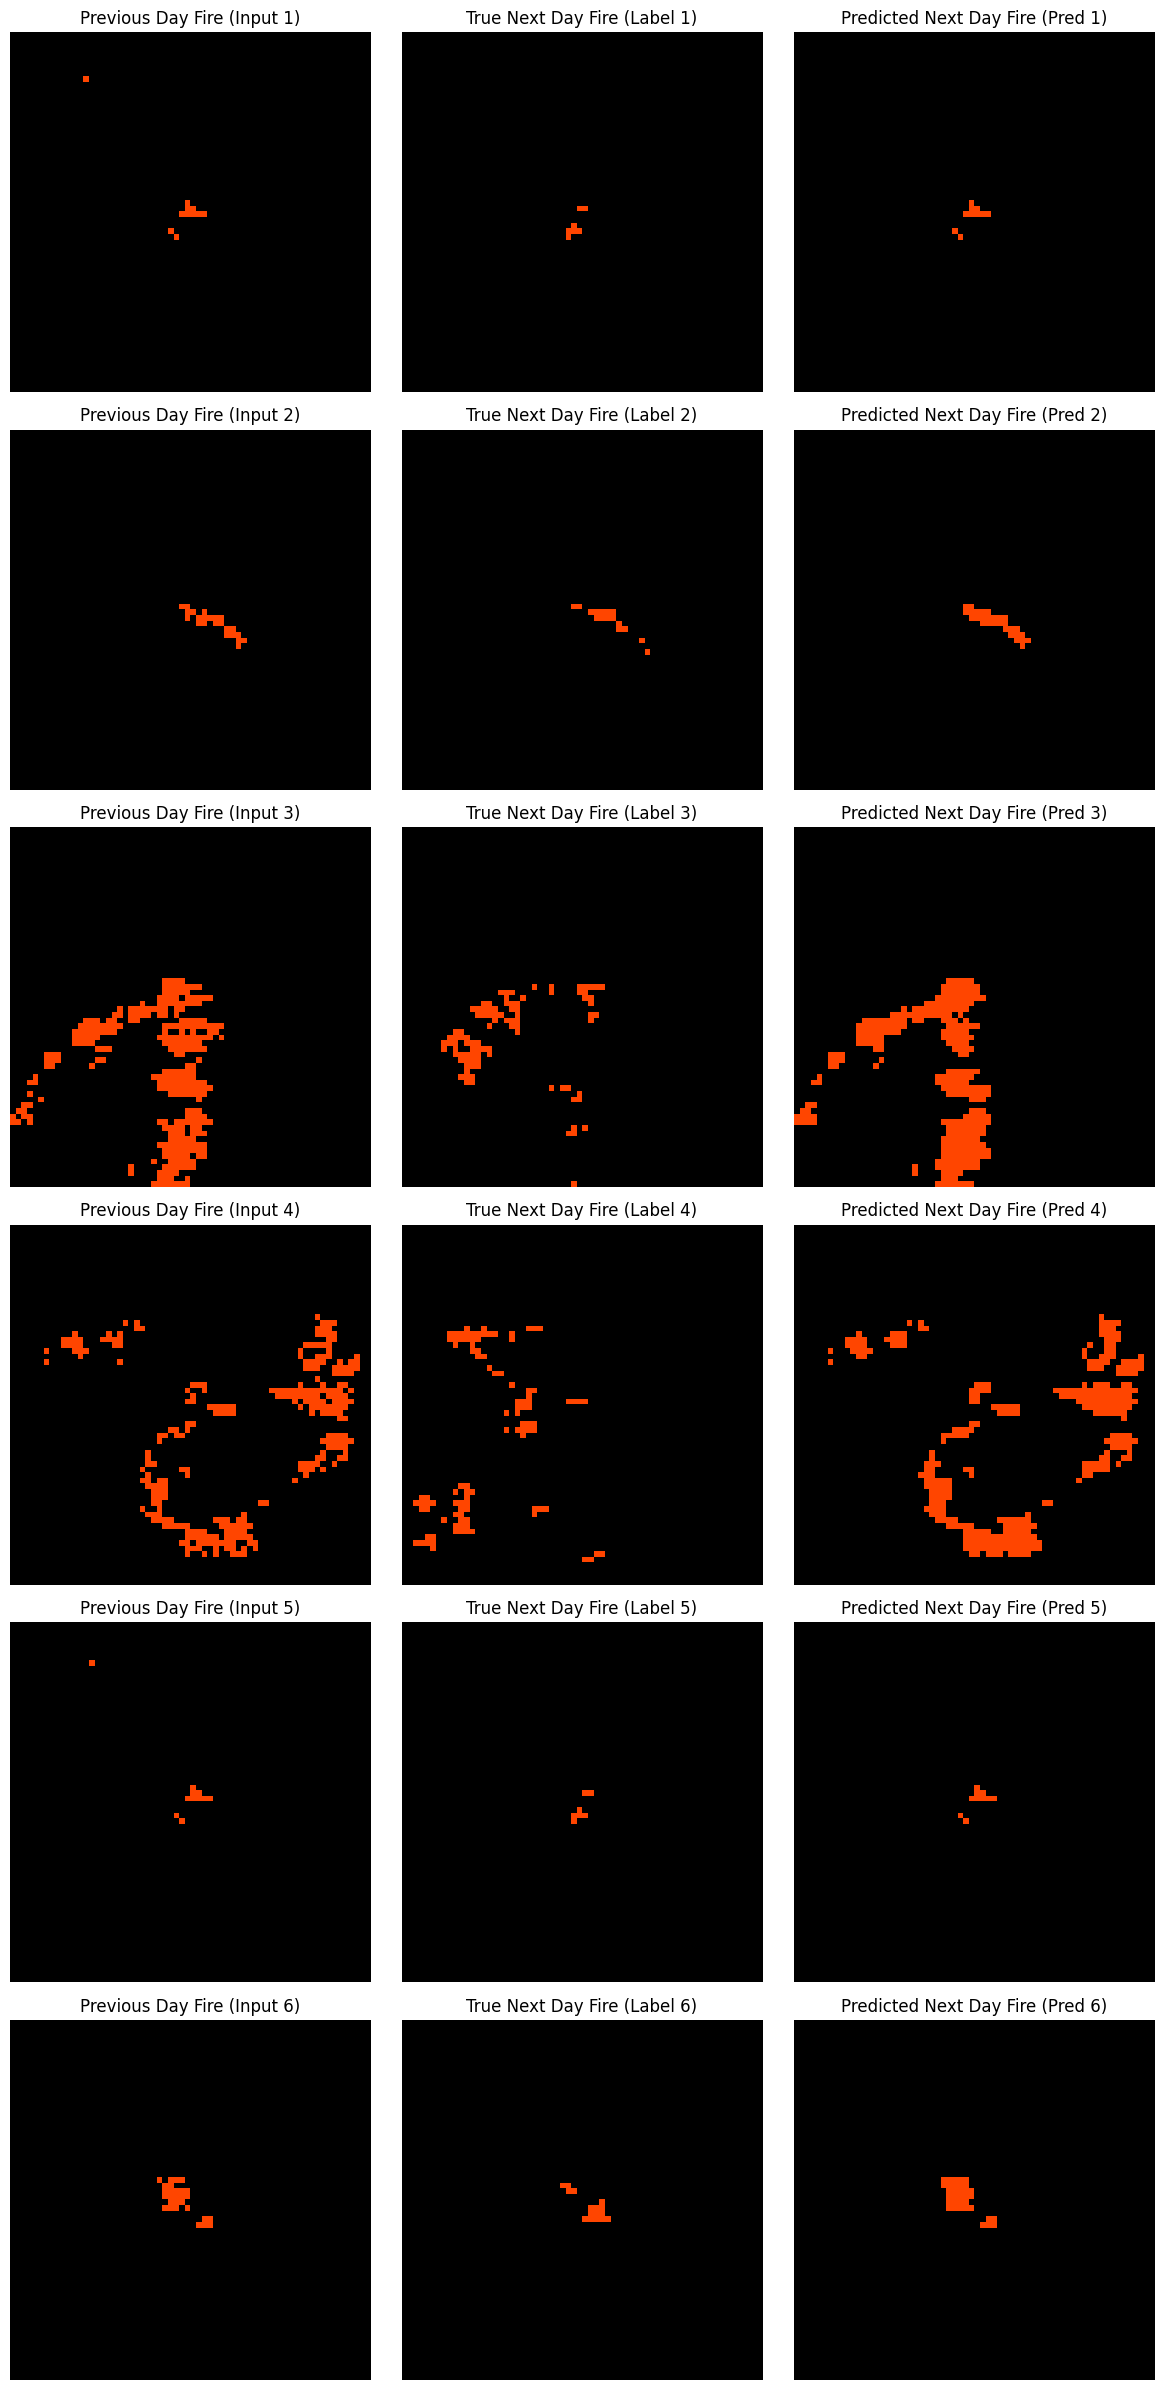

In [ ]:
def show_inference_tf(model: tf.keras.Model, dataset: tf.data.Dataset, n_rows: int = 6, threshold: float = 0.5):
    if dataset is None:
        print("Dataset is None. Cannot show inference.")
        return

    try:
        features, labels = next(iter(dataset))
    except StopIteration:
         print("Could not get a batch from the dataset for inference.")
         print("Attempting to re-initialize iterator...")
         try:
             temp_test_dataset = get_dataset(test_files_pattern, batch_size=BATCH_SIZE, shuffle=False, repeat=False)
             features, labels = next(iter(temp_test_dataset))
         except Exception as e:
             print(f"Failed to get batch even after re-init: {e}")
             return
    except Exception as e:
         print(f"Error getting batch for inference: {e}")
         return


    predictions = model.predict(features)
    predictions_binary = tf.cast(predictions > threshold, tf.int32)

    CMAP_MASK = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-0.1, 0.1, 1.1]
    NORM_MASK = colors.BoundaryNorm(BOUNDS, CMAP_MASK.N)

    actual_rows = min(n_rows, features.shape[0])
    fig, axes = plt.subplots(actual_rows, 3, figsize=(12, actual_rows * 4))
    if actual_rows == 1: axes = axes.reshape(1,-1)

    try:
        prev_fire_idx = INPUT_FEATURES.index('viirs_PrevFireMask')
    except ValueError:
        print("Warning: 'viirs_PrevFireMask' not found in INPUT_FEATURES. Cannot display previous fire.")
        prev_fire_idx = -1


    for i in range(actual_rows):
        ax1 = axes[i, 0]
        if prev_fire_idx != -1:
            prev_fire_map = features[i, :, :, prev_fire_idx].numpy()
            ax1.imshow((prev_fire_map > 0.1).astype(int), cmap=CMAP_MASK, norm=NORM_MASK)
            ax1.set_title(f"Previous Day Fire (Input {i+1})")
        else:
            ax1.set_title(f"Prev Fire N/A (Input {i+1})")
            ax1.imshow(np.zeros((IMG_HEIGHT, IMG_WIDTH)), cmap='gray')
        ax1.axis('off')

        ax2 = axes[i, 1]
        true_fire_map = labels[i, :, :, 0].numpy()
        ax2.imshow(true_fire_map, cmap=CMAP_MASK, norm=NORM_MASK)
        ax2.set_title(f"True Next Day Fire (Label {i+1})")
        ax2.axis('off')

        ax3 = axes[i, 2]
        pred_fire_map = predictions_binary[i, :, :, 0].numpy()
        ax3.imshow(pred_fire_map, cmap=CMAP_MASK, norm=NORM_MASK)
        ax3.set_title(f"Predicted Next Day Fire (Pred {i+1})")
        ax3.axis('off')

    plt.tight_layout()
    plt.show()

if test_dataset:
    print("\nVisualizing predictions on Test Set using the best model...")
    plot_test_dataset = get_dataset(test_files_pattern, batch_size=BATCH_SIZE, shuffle=False, repeat=False)
    if plot_test_dataset:
        show_inference_tf(best_model, plot_test_dataset, n_rows=6)
    else:
        print("Could not create a non-repeated test dataset for plotting.")
else:
    print("Skipping prediction visualization: Test dataset not available.")

Saving Model

In [ ]:
final_model_path_keras = "final_unet_model.keras"
final_model_path_savedmodel = "final_unet_model_savedmodel"

print(f"\nSaving the final model state (after last epoch)...")

try:T
    unet_model.save(final_model_path_keras)
    print(f"Final model saved in Keras format to: {final_model_path_keras}")
except Exception as e:
    print(f"Error saving final model in Keras format: {e}")

try:
    unet_model.save(final_model_path_savedmodel, save_format='tf')
    print(f"Final model saved in SavedModel format to directory: {final_model_path_savedmodel}")
    print("Contents of SavedModel directory:")
    !ls -l {final_model_path_savedmodel}
except Exception as e:
    print(f"Error saving final model in SavedModel format: {e}")


print(f"\nReminder: The *best* performing model (based on val_dice_coeff during training)")
print(f"was saved by ModelCheckpoint to: best_unet_model.keras")
T


Saving the final model state (after last epoch)...
Final model saved in Keras format to: final_unet_model.keras
Error saving final model in SavedModel format: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

Reminder: The *best* performing model (based on val_dice_coeff during training)
was saved by ModelCheckpoint to: best_unet_model.keras
